In [62]:
import os
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
import joblib
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [64]:
df = pd.read_csv("Drumsticks - BatDatacsv.csv")
# df = df.drop(columns=['MatchDate'])

In [65]:
df.columns

Index(['ID', 'GameFormat', 'SR', 'BattingInnings', 'IsOut', 'Opposition',
       'Ground', 'TossResult', 'MatchTime', 'isTossWon', 'Fantasy',
       'isHomeGround', 'GroundWL', 'GroundRPO', 'GroundAvg', 'TossWL',
       'TossRPO', 'TossAvg', 'inningsWL', 'inningsRPO', 'inningsAverage',
       'Average', 'Innings', 'Centuries', 'Fifties', 'Zeros', 'Consistency',
       'Form', 'Venue', 'Opps', 'MaxTemp', 'MinTemp', 'MaxWind', 'Tournament',
       'BattingOrder', 'Role', 'Country', 'Batting Hand', 'Age'],
      dtype='object')

In [66]:
df

,ID,GameFormat,SR,BattingInnings,IsOut,Opposition,Ground,TossResult,MatchTime,isTossWon,...,Opps,MaxTemp,MinTemp,MaxWind,Tournament,BattingOrder,Role,Country,Batting Hand,Age
0,28081,6,0.000000,2,1,South Africa,Johannesburg,bat,night,0,...,1.0927,25.3,13.6,15.9,Bilateral,2,WK,India,RHB,25
1,28081,3,0.000000,2,1,South Africa,Johannesburg,bat,night,0,...,1.0927,25.3,13.6,15.9,Bilateral,2,WK,India,RHB,25
2,44828,6,0.000000,2,1,Eagles,Centurion,bat,day,0,...,1.0927,32.6,16.5,24.5,Other,1,BAT,South Africa,RHB,23
3,44828,6,173.684211,1,1,Warriors,Gqeberha,bat,night,1,...,1.0927,25.5,20.3,28.6,Other,1,BAT,South Africa,RHB,23
4,44828,6,150.000000,2,1,Cape Cobras,Cape Town,bat,night,0,...,1.0927,27.9,17.3,26.7,Other,1,BAT,South Africa,RHB,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24273,600498,6,134.407849,2,1,MI Cape Town,Johannesburg,bat,daynight,0,...,3.0623,26.5,14.4,10.4,SA20,2,BAT,South African,RHB,31
24274,696401,6,142.971888,2,1,MI Cape Town,Johannesburg,bat,daynight,0,...,3.0623,26.5,14.4,10.4,SA20,3,ALL,South Africa,RHB,25
24275,662973,6,133.974558,1,0,DC,Dubai (DICS),field,night,0,...,3.5755,22.9,19.1,18.6,T20 Tournament,2,ALL,England,LHB,27
24276,820351,6,138.502446,2,1,Vipers,Dubai (DICS),field,night,1,...,3.4015,22.9,19.1,18.6,T20 Tournament,2,BAT,West Indies,RHB,32


In [67]:
y = df["Fantasy"]
df.drop("Fantasy", axis = 1, inplace = True)

In [68]:
y = pd.DataFrame(y)

In [69]:
from sklearn.preprocessing import LabelEncoder

In [70]:
y.loc[y["Fantasy"] < 0, "Fantasy_Class"] = 1
y.loc[(y["Fantasy"] < 40) & (y["Fantasy"] >= 0), "Fantasy_Class"] = 2
y.loc[(y["Fantasy"] < 80) & (y["Fantasy"] >= 40), "Fantasy_Class"] = 3
y.loc[(y["Fantasy"] < 120) & (y["Fantasy"] >= 80), "Fantasy_Class"] = 4
y.loc[y["Fantasy"] >= 120, "Fantasy_Class"] = 5

In [71]:
import pickle

In [72]:
encoder_y = LabelEncoder()
y["Fantasy_Class"] = encoder_y.fit_transform(y["Fantasy_Class"])
y.drop("Fantasy", axis = 1, inplace = True)

# Saving the encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder_y, f)

# Loading the encoder
with open('label_encoder.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)

In [73]:
y

,Fantasy_Class
0,0
1,0
2,2
3,0
4,1
...,...
24273,1
24274,1
24275,4
24276,4


In [74]:
df.columns

Index(['ID', 'GameFormat', 'SR', 'BattingInnings', 'IsOut', 'Opposition',
       'Ground', 'TossResult', 'MatchTime', 'isTossWon', 'isHomeGround',
       'GroundWL', 'GroundRPO', 'GroundAvg', 'TossWL', 'TossRPO', 'TossAvg',
       'inningsWL', 'inningsRPO', 'inningsAverage', 'Average', 'Innings',
       'Centuries', 'Fifties', 'Zeros', 'Consistency', 'Form', 'Venue', 'Opps',
       'MaxTemp', 'MinTemp', 'MaxWind', 'Tournament', 'BattingOrder', 'Role',
       'Country', 'Batting Hand', 'Age'],
      dtype='object')

In [86]:
from sklearn.preprocessing import LabelEncoder
import pickle

cols = ['ID', 'BattingInnings', 'Opposition', 'Ground', 'TossResult', 'MatchTime', 'Tournament', 'Role',
       'Country', 'Batting Hand', 'GameFormat', 'IsOut', 'isTossWon', 'isHomeGround', ]

encoders = {}  # Dictionary to store encoders

for col in cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # Store the encoder for the column

# Save all encoders to a file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

In [ ]:
# Check the distribution of classes
class_distribution = y.value_counts()

# Print the class distribution
print("Class distribution in y_train:")
print(class_distribution)

# Optionally, calculate the percentage of each class
class_percentage = y.value_counts(normalize=True) * 100
print("\nClass percentage in y_train:")
print(class_percentage)

Class distribution in y_train:
Fantasy_Class
1                12054
3                 6000
4                 6000
2                 5170
0                 3097
Name: count, dtype: int64

Class percentage in y_train:
Fantasy_Class
1                49.649889
2                21.295000
0                12.756405
3                 9.280007
4                 7.018700
Name: proportion, dtype: float64


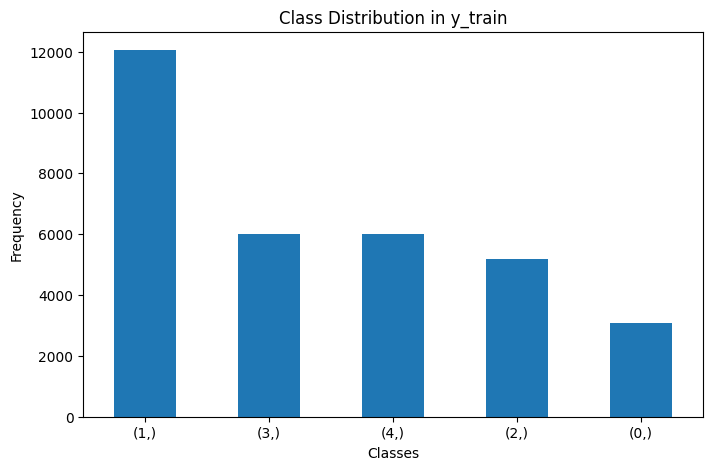

In [94]:
# Plotting the class distribution
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar')
plt.title('Class Distribution in y_train')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [89]:
class_counts = y.value_counts()
print("Class distribution before SMOTE:")
print(class_counts)

# Define the indices of the categorical features
categorical_indices = [0, 1]  # Replace with the actual indices of your categorical features

# Adjust the sampling strategy based on class distribution
sampling_strategy = {3: class_counts[3], 4: class_counts[4]}  # Set to original counts

Class distribution before SMOTE:
Fantasy_Class
1                12054
2                 5170
0                 3097
3                 2253
4                 1704
Name: count, dtype: int64


In [90]:
sampling_strategy

{3: np.int64(2253), 4: np.int64(1704)}

In [92]:
from imblearn.over_sampling import SMOTENC

# Initialize SMOTENC with specified categorical features and adjusted sampling strategy
smote_nc = SMOTENC(categorical_features=cols, sampling_strategy={3: 6000, 4: 6000})

# Resample the dataset
x_resampled, y_resampled = smote_nc.fit_resample(df, y)

# Convert y_resampled to a 1D Series for counting
new_class_counts = y_resampled.value_counts()

# Print the new class distribution
print("Class distribution after SMOTE:")
print(new_class_counts)

Class distribution after SMOTE:
Fantasy_Class
1                12054
3                 6000
4                 6000
2                 5170
0                 3097
Name: count, dtype: int64


In [78]:
# smote = SMOTE()
# x_resampled, y_resampled = smote.fit_resample(df, y)

ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 2253 samples and 0.2 samples are asked.

In [95]:
x_resampled

,ID,GameFormat,SR,BattingInnings,IsOut,Opposition,Ground,TossResult,MatchTime,isTossWon,...,Opps,MaxTemp,MinTemp,MaxWind,Tournament,BattingOrder,Role,Country,Batting Hand,Age
0,2,1,0.000000,1,1,235,91,0,2,0,...,1.092700,25.300000,13.600000,15.900000,1,2,3,5,1,25
1,2,0,0.000000,1,1,235,91,0,2,0,...,1.092700,25.300000,13.600000,15.900000,1,2,3,5,1,25
2,5,1,0.000000,1,1,66,36,0,0,0,...,1.092700,32.600000,16.500000,24.500000,6,1,1,8,1,23
3,5,1,173.684211,0,1,281,75,0,2,1,...,1.092700,25.500000,20.300000,28.600000,6,1,1,8,1,23
4,5,1,150.000000,1,1,40,33,0,2,0,...,1.092700,27.900000,17.300000,26.700000,6,1,1,8,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32316,122,1,159.791897,1,1,70,187,1,1,1,...,1.987395,29.242377,20.746872,17.325996,6,1,1,5,0,24
32317,21,1,159.251599,1,1,37,187,1,2,0,...,1.092700,35.622855,24.880884,27.050552,4,2,0,1,1,26
32318,81,1,129.773849,0,1,15,36,0,0,1,...,1.957895,24.036620,5.703973,13.154428,6,1,3,8,1,20
32319,121,1,135.464610,0,1,37,2,1,1,0,...,3.521292,41.106949,27.105015,25.231662,4,1,1,5,1,24


In [96]:
from sklearn.model_selection import train_test_split

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.1, random_state=42)

In [98]:
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [21]:
print("Features and their value ranges in x_train:")
for column in x_train.columns:
    min_value = x_train[column].min()
    max_value = x_train[column].max()
    print(f"{column}: Range = [{min_value}, {max_value}]")

Features and their value ranges in x_train:
ID: Range = [0, 197]
GameFormat: Range = [3, 6]
SR: Range = [0.0, 480.0]
BattingInnings: Range = [0, 1]
IsOut: Range = [0, 1]
Opposition: Range = [0, 298]
Ground: Range = [0, 192]
TossResult: Range = [0, 1]
MatchTime: Range = [0, 2]
isTossWon: Range = [0, 1]
isHomeGround: Range = [0, 1]
GroundWL: Range = [0.0, 4.375]
GroundRPO: Range = [0.0, 11.15]
GroundAvg: Range = [0.0, 55.0]
TossWL: Range = [0.0, 6.0]
TossRPO: Range = [0.0, 11.65]
TossAvg: Range = [0.0, 83.5]
inningsWL: Range = [0.0, 4.666]
inningsRPO: Range = [5.36, 11.15]
inningsAverage: Range = [11.7, 55.0]
Average: Range = [0.0, 180.0]
Innings: Range = [0, 582]
Centuries: Range = [0, 13]
Fifties: Range = [0, 134]
Zeros: Range = [0, 49]
Consistency: Range = [0.9025, 4.5716]
Form: Range = [0.9025, 3.8155]
Venue: Range = [1.3382, 4.709300000000001]
Opps: Range = [1.0927000000000002, 4.696500000000001]
MaxTemp: Range = [0.0, 45.9]
MinTemp: Range = [0.0, 32.4]
RainProb: Range = [0.0, 63.1]

In [ ]:
# Hyper parameter eta tuning based on validation score

accuracyEta = []
Eta = []
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')
for eta in range(100, 600, 200):
  clf = xgb.XGBClassifier(
        n_estimators=eta, max_depth=15, learning_rate=0.1,
        eval_metric="logloss", colsample_bytree=0.8, subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
  )
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_validation)
  accuracyEta.append(accuracy_score(y_validation, y_pred))
  Eta.append(eta)
  line.set_xdata(Eta)
  line.set_ydata(accuracyEta)

  ax.relim()  # Recalculate limits
  ax.autoscale_view()  # Rescale the view

  plt.draw()
  plt.pause(0.1)  # Pause to update the figure
  time.sleep(0.1)
  plt.plot(Eta, accuracyEta)

In [ ]:
# Hyper parameter depth tuning based on validation score


accuracyDepth = []
Depth = []
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')
for depth in range(6, 25, 4):
  clf = xgb.XGBClassifier(
        n_estimators=500, max_depth=depth, learning_rate=0.1,
        eval_metric="logloss", colsample_bytree=0.8, subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
    )
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_validation)
  accuracyDepth.append(accuracy_score(y_validation, y_pred))
  Depth.append(depth)
  line.set_xdata(Depth)
  line.set_ydata(accuracyDepth)

  ax.relim()  # Recalculate limits
  ax.autoscale_view()  # Rescale the view

  plt.draw()
  plt.pause(0.1)  # Pause to update the figure
  time.sleep(0.1)
  plt.plot(Depth, accuracyDepth)

In [ ]:
# From Graph

eta = 300
depth = 10

clf = xgb.XGBClassifier(
        n_estimators=eta, max_depth=10, learning_rate=0.1,
        eval_metric="logloss", colsample_bytree=0.8, subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
  )
clf.fit(x_train, y_train)
# clf = xgb.XGBClassifier(
#        n_estimators=eta, 
#        max_depth=10, 
#        learning_rate=0.1,
#        eval_metric="logloss", 
#        colsample_bytree=0.8, 
#        subsample=0.8,
#        tree_method='hist',
#        device='cuda',
#        objective='multi:softmax',
#        enable_categorical=True,
#        reg_alpha=1,  # L1 regularization
#        reg_lambda=1  # L2 regularization
#        )

In [ ]:
# evals = [(x_train, y_train), (x_validation, y_validation)]
# clf.fit(x_train, y_train, eval_set=evals)

In [ ]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(clf, x_train, y_train, cv=5)  # 5-fold cross-validation
# print(f'Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
#     }

# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3)
# grid_search.fit(x_train, y_train)
# print(f'Best Parameters: {grid_search.best_params_}')

In [ ]:
# Calculate training accuracy
train_accuracy = clf.score(x_train, y_train)

# Print the training accuracy
print(f'Training Accuracy: {train_accuracy:.4f}')

# Calculate validation accuracy
val_accuracy = clf.score(x_validation, y_validation)

# Print the validation accuracy
print(f'Validation Accuracy: {val_accuracy:.4f}')

In [ ]:
# Calculate precision, recall, and F1-score for each class
report = classification_report(y_validation, y_pred, target_names=[str(i) for i in range(5)], output_dict=True)

# Extract metrics for classes 4, 3, 2, 1, and 0
metrics = {key: report[key] for key in report.keys() if key in ['0', '1', '2', '3', '4']}

# Print the metrics
for class_label, metrics in metrics.items():
    print(f"Class {class_label}:")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-score: {metrics['f1-score']:.4f}")
    print(f"  Support: {metrics['support']}\n")

In [24]:
# y_pred = clf.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(accuracy)

In [ ]:
# import xgboost as xgb
# from sklearn.metrics import accuracy_score

# # Initialize the classifier
# clf = xgb.XGBClassifier(
#     n_estimators=1000,  # Set a high number of estimators
#     max_depth=10, 
#     learning_rate=0.1,
#     eval_metric="logloss", 
#     colsample_bytree=0.8, 
#     subsample=0.8,
#     tree_method='hist',
#     device='cuda',
#     objective='multi:softmax',
#     enable_categorical=True
# )

# # Fit the model without early stopping
# clf.fit(x_train, y_train)

In [ ]:
# # Monitor validation accuracy
# best_val_accuracy = 0
# patience = 10  # Number of rounds to wait for improvement
# stopping_rounds = 0

# for i in range(25, 50):  # Loop through a high number of iterations
#     clf.n_estimators = i + 1  # Increment the number of estimators
#     clf.fit(x_train, y_train)  # Fit the model
#     train_accuracy = clf.score(x_train, y_train)
#     val_accuracy = clf.score(x_validation, y_validation)  # Calculate validation accuracy
#     print(f"{i}: Training Accuracy= {train_accuracy} Validation Accuracy= {val_accuracy}, Best Accuracy= {best_val_accuracy}")
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         stopping_rounds = 0  # Reset patience counter
#     else:
#         stopping_rounds += 1

#     if stopping_rounds >= patience:
#         print(f"Early stopping at iteration {i + 1}")
#         break

# # Final training and validation accuracy
# train_accuracy = clf.score(x_train, y_train)
# print(f'Training Accuracy: {train_accuracy:.4f}')
# print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:14:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


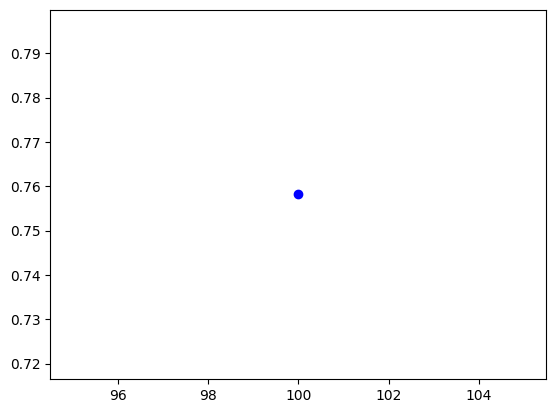

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:14:25] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 640x480 with 0 Axes>

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:14:31] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 640x480 with 0 Axes>

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:14:37] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


KeyboardInterrupt: 

In [99]:
# F1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming x_train, y_train, x_validation, and y_validation are already defined

# Initialize lists to store results
f1_scores = []
eta_values = []
best_f1_score = 0
best_eta = None

plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')

# Hyperparameter tuning based on F1-score for classes 3 and 4
for eta in range(100, 600, 50):
    clf = xgb.XGBClassifier(
        n_estimators=eta,
        max_depth=10,
        learning_rate=0.1,
        eval_metric="mlogloss",
        colsample_bytree=0.8,
        subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
    )
    
    # Fit the model
    clf.fit(x_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(x_validation)
    
    # Calculate F1-score for classes 3 and 4
    f1_class_3 = f1_score(y_validation, y_pred, labels=[3], average='macro', zero_division=0)
    f1_class_4 = f1_score(y_validation, y_pred, labels=[4], average='macro', zero_division=0)
    
    # Average F1-score for classes 3 and 4
    avg_f1_score = (f1_class_3 + f1_class_4) / 2
    
    # Store the results
    f1_scores.append(avg_f1_score)
    eta_values.append(eta)
    
    # Check if this is the best F1 score
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_eta = eta
    
    # Update the plot
    line.set_xdata(eta_values)
    line.set_ydata(f1_scores)
    ax.relim()  # Recalculate limits
    ax.autoscale_view()  # Rescale the view
    plt.draw()
    plt.pause(0.1)  # Pause to update the figure

# Finalize the plot
plt.plot(eta_values, f1_scores, label='F1 Score for Classes 3 and 4')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('F1 Score')
plt.title('Hyperparameter Tuning Based on F1 Score for Classes 3 and 4')
plt.legend()
plt.show()

# Output the best hyperparameters
print(f"Best F1 Score: {best_f1_score:.4f} with n_estimators: {best_eta}")

In [ ]:
# F1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming x_train, y_train, x_validation, and y_validation are already defined

# Initialize lists to store results
f1_scores = []
depth_values = []
best_f1_score = 0
best_depth = None

plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')

# Hyperparameter tuning based on F1-score for classes 3 and 4
for depth in range(6, 25, 4):
    clf = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=depth,
        learning_rate=0.1,
        eval_metric="mlogloss",
        colsample_bytree=0.8,
        subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
    )
    
    # Fit the model
    clf.fit(x_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(x_validation)
    
    # Calculate F1-score for classes 3 and 4
    f1_class_3 = f1_score(y_validation, y_pred, labels=[3], average='macro', zero_division=0)
    f1_class_4 = f1_score(y_validation, y_pred, labels=[4], average='macro', zero_division=0)
    
    # Average F1-score for classes 3 and 4
    avg_f1_score = (f1_class_3 + f1_class_4) / 2
    
    # Store the results
    f1_scores.append(avg_f1_score)
    depth_values.append(depth)
    
    # Check if this is the best F1 score
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_depth = depth
    
    # Update the plot
    line.set_xdata(depth_values)
    line.set_ydata(f1_scores)
    ax.relim()  # Recalculate limits
    ax.autoscale_view()  # Rescale the view
    plt.draw()
    plt.pause(0.1)  # Pause to update the figure

# Finalize the plot
plt.plot(depth_values, f1_scores, label='F1 Score for Classes 3 and 4')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.title('Hyperparameter Tuning Based on F1 Score for Classes 3 and 4')
plt.legend()
plt.show()

# Output the best hyperparameters
print(f"Best F1 Score: {best_f1_score:.4f} with max_depth: {best_depth}")

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:18:24] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:18:29] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:18:36] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/p

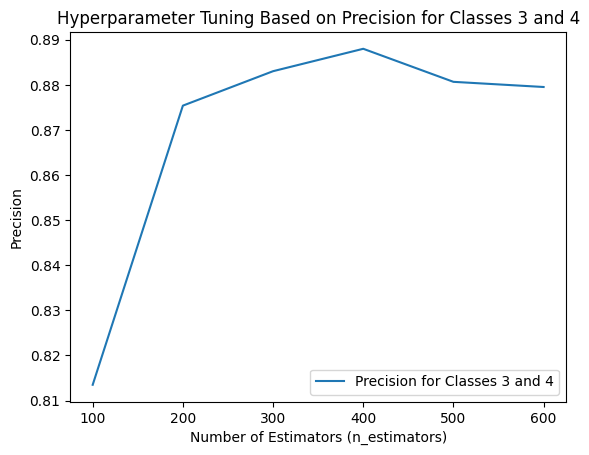

Best Precision Score: 0.8880 with n_estimators: 400


In [101]:
# Precision on Class 3 and 4

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming x_train, y_train, x_validation, and y_validation are already defined

# Initialize lists to store results
precision_scores = []
eta_values = []
best_precision_score = 0
best_eta = None

plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')

# Hyperparameter tuning based on precision for classes 3 and 4
for eta in range(100, 650, 100):
    clf = xgb.XGBClassifier(
        n_estimators=eta,
        max_depth=10,
        learning_rate=0.1,
        eval_metric="mlogloss",
        colsample_bytree=0.8,
        subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
    )
    
    # Fit the model
    clf.fit(x_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(x_validation)
    
    # Calculate precision for classes 3 and 4
    precision_class_3 = precision_score(y_validation, y_pred, labels=[3], average='macro', zero_division=0)
    precision_class_4 = precision_score(y_validation, y_pred, labels=[4], average='macro', zero_division=0)
    
    # Average precision for classes 3 and 4
    avg_precision_score = (precision_class_3 + precision_class_4) / 2
    
    # Store the results
    precision_scores.append(avg_precision_score)
    eta_values.append(eta)
    
    # Check if this is the best precision score
    if avg_precision_score > best_precision_score:
        best_precision_score = avg_precision_score
        best_eta = eta

# Finalize the plot
plt.plot(eta_values, precision_scores, label='Precision for Classes 3 and 4')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Precision')
plt.title('Hyperparameter Tuning Based on Precision for Classes 3 and 4')
plt.legend()
plt.show()

# Output the best hyperparameters
print(f"Best Precision Score: {best_precision_score:.4f} with n_estimators: {best_eta}")

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:20:03] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:20:09] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/p

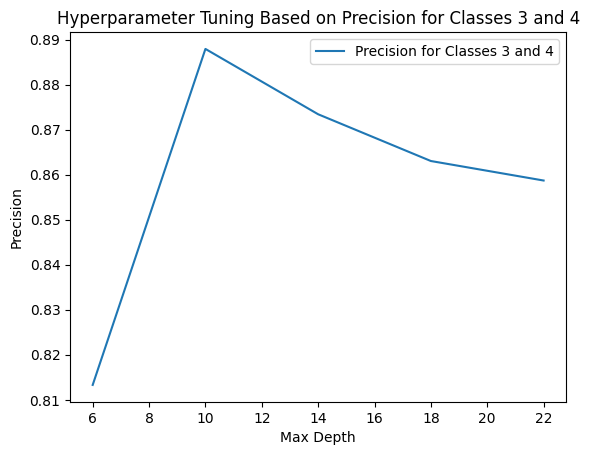

Best Precision Score: 0.8880 with max_depth: 10


In [102]:
# Precision on Class 3 and 4

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming x_train, y_train, x_validation, and y_validation are already defined

# Initialize lists to store results
precision_scores = []
depth_values = []
best_precision_score = 0
best_depth = None

plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')

# Hyperparameter tuning based on precision for classes 3 and 4
for depth in range(6, 25, 4):
    clf = xgb.XGBClassifier(
        n_estimators=best_eta,
        max_depth=depth,
        learning_rate=0.1,
        eval_metric="mlogloss",
        colsample_bytree=0.8,
        subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
    )
    
    # Fit the model
    clf.fit(x_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(x_validation)
    
    # Calculate precision for classes 3 and 4
    precision_class_3 = precision_score(y_validation, y_pred, labels=[3], average='macro', zero_division=0)
    precision_class_4 = precision_score(y_validation, y_pred, labels=[4], average='macro', zero_division=0)
    
    # Average precision for classes 3 and 4
    avg_precision_score = (precision_class_3 + precision_class_4) / 2
    
    # Store the results
    precision_scores.append(avg_precision_score)
    depth_values.append(depth)
    
    # Check if this is the best precision score
    if avg_precision_score > best_precision_score:
        best_precision_score = avg_precision_score
        best_depth = depth

# Finalize the plot
plt.plot(depth_values, precision_scores, label='Precision for Classes 3 and 4')
plt.xlabel('Max Depth')
plt.ylabel('Precision')
plt.title('Hyperparameter Tuning Based on Precision for Classes 3 and 4')
plt.legend()
plt.show()

# Output the best hyperparameters
print(f"Best Precision Score: {best_precision_score:.4f} with max_depth: {best_depth}")

In [103]:
# max_depth: 10
# n_estimators: 650

eta = 400
depth = 10

clf = xgb.XGBClassifier(
        n_estimators=eta,
        max_depth=depth,
        learning_rate=0.1,
        eval_metric="mlogloss",
        colsample_bytree=0.8,
        subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
    )
clf.fit(x_train, y_train)

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:22:49] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [104]:
# Calculate training accuracy
train_accuracy = clf.score(x_train, y_train)

# Print the training accuracy
print(f'Training Accuracy: {train_accuracy:.4f}')

# Calculate validation accuracy
val_accuracy = clf.score(x_validation, y_validation)

# Print the validation accuracy
print(f'Validation Accuracy: {val_accuracy:.4f}')

Training Accuracy: 1.0000
Validation Accuracy: 0.7370


In [105]:

y_pred = clf.predict(x_test)
# Calculate precision, recall, and F1-score for each class
report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(5)], output_dict=True)

# Extract metrics for classes 4, 3, 2, 1, and 0
metrics = {key: report[key] for key in report.keys() if key in ['0', '1', '2', '3', '4']}

# Print the metrics
for class_label, metrics in metrics.items():
    print(f"Class {class_label}:")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-score: {metrics['f1-score']:.4f}")
    print(f"  Support: {metrics['support']}\n")

Class 0:
  Precision: 0.7727
  Recall: 0.4304
  F1-score: 0.5528
  Support: 158.0

Class 1:
  Precision: 0.6654
  Recall: 0.8592
  F1-score: 0.7500
  Support: 618.0

Class 2:
  Precision: 0.6057
  Recall: 0.4309
  F1-score: 0.5036
  Support: 246.0

Class 3:
  Precision: 0.8365
  Recall: 0.7483
  F1-score: 0.7899
  Support: 294.0

Class 4:
  Precision: 0.8601
  Recall: 0.8372
  F1-score: 0.8485
  Support: 301.0



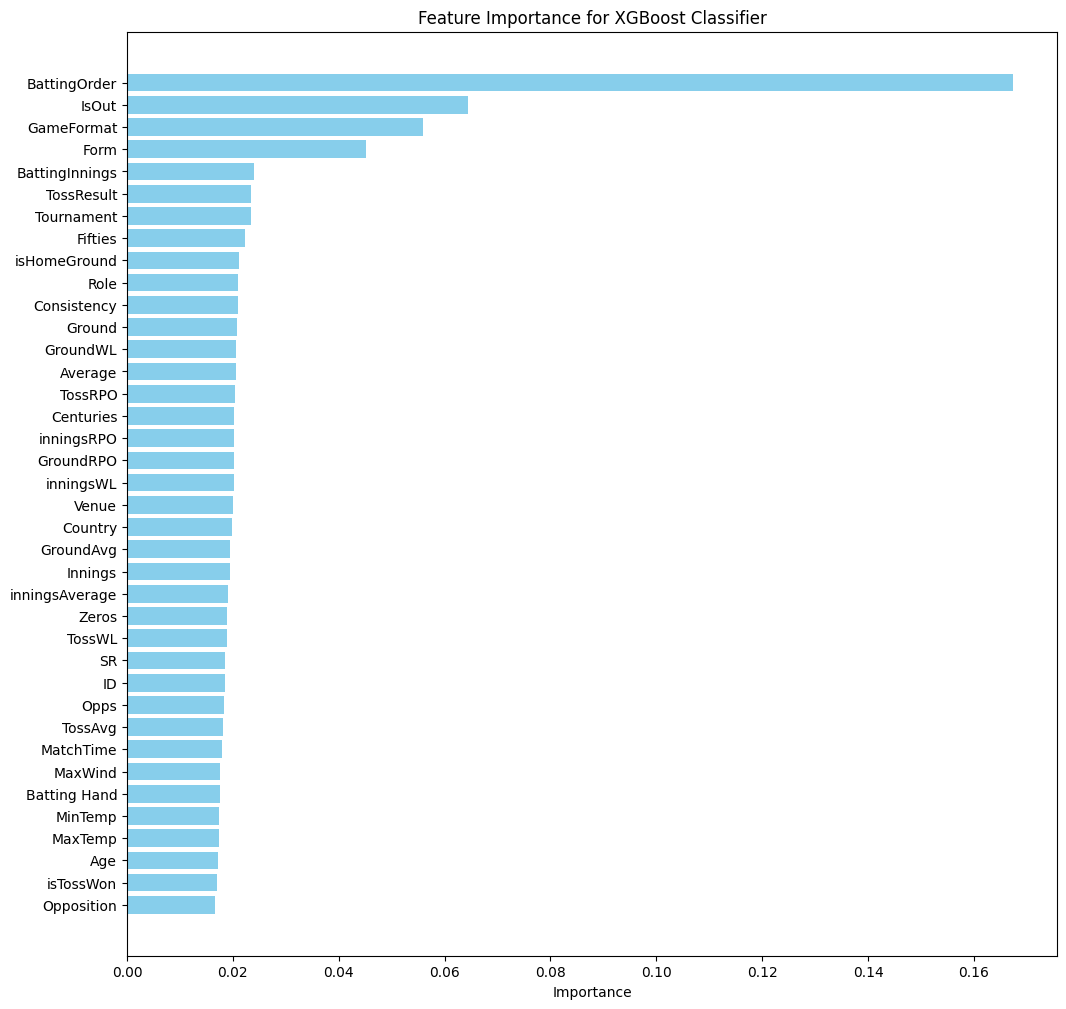

In [106]:
# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': df.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 12))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for XGBoost Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [ ]:
feature_importance_df